# Movies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from ipywidgets import interact

In [2]:
import lmfit
import h5py

from skimage.restoration import unwrap_phase

In [28]:
from lib_lt.tools import recursive_read_attrs
from glom import glom

In [79]:
%matplotlib notebook

In [5]:
root = Path('/home/carmelo/lense_thirring/code/bh3')

In [97]:
# h5filename = root / 'run/0015/bh_0000.h5'
h5filename = root / 'run/0024/bh_0000.h5'

In [98]:
conf = recursive_read_attrs(h5filename, 'configure')

with h5py.File(h5filename, 'r') as f:
    g = f[f"realtime/1"]
#     g = f[f"imprint_pair/1"]
    x = g['x'][:]
    y = g['y'][:]
    t = g['t'][:]
    psiI = g['psiI'][:]
    psiR = g['psiR'][:]
    
#     n0 = f['groundstate/1/psiI'][:]**2 + f['groundstate/1/psiR'][:]**2
    n0 = 0
    
L = len(x) // 2

r = x[L:]

# radial_slice = np.index_exp[L:0:-1, L]
radial_slice = np.index_exp[L, L:]

extent = (x.min(), x.max(), y.min(), y.max())

density = psiR**2 + psiI**2
N = density.sum(axis=(1, 2))
_phase = np.arctan2(psiI, psiR)

X, Y = np.meshgrid(x, y, indexing='ij')
R = np.hypot(X, Y)
phi = np.arctan2(Y, X)

In [99]:
t.shape, t[-1]

((400,), 50.000000010270924)

In [100]:
def vgaussian(x, amp, mx, sx, n0):
    return n0 - amp * np.exp(-(x - mx)**2 / 2 / sx**2)

M = lmfit.Model(vgaussian)
p0 = M.make_params(amp=150, n0=150, mx=0, sx=2)

In [103]:
try:
    xv = glom(conf, "imprint_pair.globals.xv")
except KeyError as e:
    xv = glom(conf, "globals.xv")
# dv = 2  # run 0015
dv = 0.8  # run 0023

ix_xv = np.argmin(abs(x - xv))
ix_yv = np.argmin(abs(y - dv))

v_slice_r = np.index_exp[L:, ix_yv]
v_slice_y = np.index_exp[ix_xv, :]

<IPython.core.display.Javascript object>


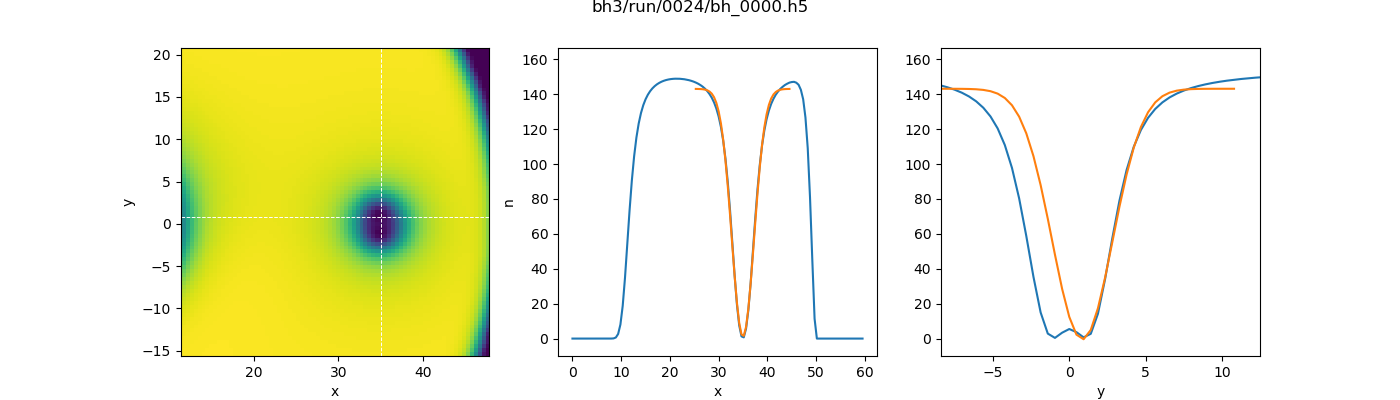

[[Model]]
    Model(vgaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 42
    # variables        = 4
    chi-square         = 177.795516
    reduced chi-square = 4.67882937
    Akaike info crit   = 68.6045084
    Bayesian info crit = 75.5551869
[[Variables]]
    amp:  141.907965 +/- 0.97989460 (0.69%) (init = 150)
    mx:   34.9848050 +/- 0.01672339 (0.05%) (init = 35)
    sx:   2.27580895 +/- 0.02069053 (0.91%) (init = 2)
    n0:   143.070870 +/- 0.53749884 (0.38%) (init = 150)
[[Correlations]] (unreported correlations are < 0.100)
    C(sx, n0)  =  0.589
    C(amp, n0) =  0.388
    C(amp, sx) = -0.202

[[Model]]
    Model(vgaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 21
    # variables        = 4
    chi-square         = 129.564594
    reduced chi-square = 7.62144670
    Akaike info crit   = 46.2127994
    Bayesian info crit = 50.3908891
[[Variables]]

In [104]:
fig, (ax, ax0, ax1) = plt.subplots(1, 3, figsize=(14, 4))
ax0.get_shared_y_axes().join(ax0, ax1)
fig.suptitle('/'.join(h5filename.parts[-4:]), y=1)

ix = 0
n = density[ix]

nx = n[v_slice_r]
ny = n[v_slice_y]

ax.imshow(np.rot90(n), extent=(x.min(), x.max(), y.min(), y.max()))
R = abs(x.max())
ax.set(xlabel='x', ylabel='y', xlim=(-R, R), ylim=(-R, R))

lkw = dict(ls='--', color='w', lw=0.7)
ax.axhline(dv, **lkw)
ax.axvline(xv, **lkw)


p0['mx'].set(value=xv)
wh = abs(r - xv) < 10
_r = r[wh]
res_x = M.fit(nx[wh], p0, x=_r)
print(res_x.fit_report())

p0['mx'].set(value=dv)
if dv < 0:
    wh = (y > -10) & (y < 0)
else:
    wh = (y > 0) & (y < 10)
_y = y[wh]
res_y = M.fit(ny[wh], p0, x=_y)
print(res_y.fit_report())


ax0.plot(r, nx)
ax0.plot(_r, res_x.best_fit)

ax1.plot(y, ny)
y1 = y[abs(y - dv) < 10]
ax1.plot(y1, res_y.eval(x=y1))


ax0.set(xlabel='x', ylabel='n');
ax1.set(xlabel='y');

In [95]:
dx = np.diff(x).mean()
dx

0.46875

In [93]:
1.9 / dx

4.053333333333333

In [94]:
1.6 / dx

3.4133333333333336